In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications import MobileNet, EfficientNetB3
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

2025-10-22 23:02:36.880402: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-22 23:02:36.891995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761166956.907170 1007678 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761166956.911721 1007678 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-22 23:02:36.925945: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Note: Use conda tf-gpu environment. Copy of exp3 with more data

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
spec_dir = '../data/image_data/'
sample_dir = '../data/image_data/Polistes_dominula/'

paths_sample_plot = [join(sample_dir, f) for f in listdir(sample_dir) if isfile(join(sample_dir, f))]

- (b) View Batch

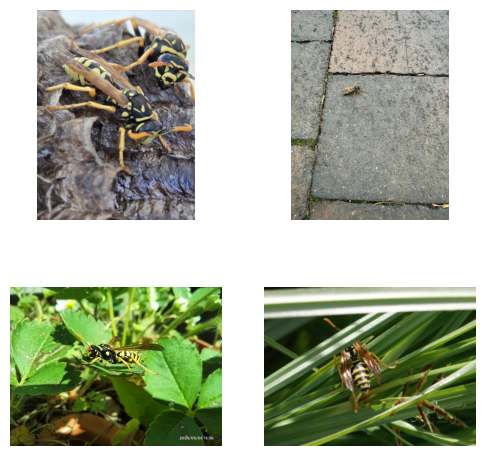

In [4]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]));

Define Batch size

In [5]:
batch_size = 32

## B - <a name="generateurs"></a> Data Generators



In [6]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )

test_data_generator  = ImageDataGenerator(rescale = 1./255)
data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implement ```training_data```, ```valid_data``` splits


In [7]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)

#test_data  = test_data_generator.flow_from_directory(directory = spec_dir,
#                                                   target_size = (224, 224),
#                                                   class_mode = 'binary',
#                                                   batch_size = batch_size)


Found 26030 images belonging to 127 classes.
Found 6477 images belonging to 127 classes.


# II - <a name="classif"></a> Classification



In [8]:
# Model MobileNet
base_model = MobileNet(weights='imagenet', include_top=False)

# Freezer les couches
#for layer in base_model.layers:
#    layer.trainable = False


"""
# Unfreeze the last N trainable convolutional blocks
trainable = False
for layer in reversed(base_model.layers):
    if 'conv' in layer.name:
        if N == 0:
            break
        N -= 1
        trainable = True
    layer.trainable = trainable
"""

model = Sequential()
model.add(base_model) # Ajout du modèl
model.add(GlobalAveragePooling2D())
model.add(Dropout(rate=0.3))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(127, activation='softmax'))

/tmp/ipykernel_1007678/3838958738.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)
I0000 00:00:1761166962.371314 1007678 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47179 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:65:00.0, compute capability: 7.5
I0000 00:00:1761166962.372750 1007678 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46919 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:b6:00.0, compute capability: 7.5


In [9]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 12,
                                         mode = 'min',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience=4,
                                         factor=0.5,
                                         verbose=2,
                                         mode='max',
                                         min_lr = 1e-10)

In [10]:
optimizer = Adam(learning_rate=0.0001) 

In [11]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

class AveragePrecisionCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, num_classes=127):
        super().__init__()
        self.val_generator = val_generator
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for i in range(len(self.val_generator)):
            x_batch, y_batch = self.val_generator[i]  # y_batch: shape (batch_size,)
            preds = self.model.predict(x_batch, verbose=0)  # preds: shape (batch_size, num_classes)

            y_true.extend(y_batch)
            y_pred.extend(preds)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # One-hot encode y_true to match y_pred's shape
        y_true_onehot = label_binarize(y_true, classes=range(self.num_classes))

        # Compute average precision per class
        aps = []
        for i in range(self.num_classes):
            ap = average_precision_score(y_true_onehot[:, i], y_pred[:, i])
            aps.append(ap)

        macro_ap = np.mean(aps)
        print(f"\nEpoch {epoch + 1}: val_average_precision = {macro_ap:.4f}")
        logs = logs or {}
        logs['val_average_precision'] = macro_ap


In [12]:
ap_callback = AveragePrecisionCallback(val_generator=validation_data)

In [13]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(training_data, validation_data=validation_data, epochs=30, 
                    callbacks=[ap_callback,lr_plateau, early_stopping])

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1761166972.339902 1007934 service.cc:148] XLA service 0x79d12000c2a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761166972.339939 1007934 service.cc:156]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
I0000 00:00:1761166972.339946 1007934 service.cc:156]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2025-10-22 23:02:52.602518: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761166973.516982 1007934 cuda_dnn.cc:529] Loaded cuDNN version 91200
E0000 00:00:1761166974.971763 1007934 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761166975.095449 1007934 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. T

  1/814 ━━━━━━━━━━━━━━━━━━━━ 5:07:25 23s/step - accuracy: 0.0000e+00 - loss: 5.3662

E0000 00:00:1761166989.922335 1007931 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761166990.048310 1007931 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761166993.184457 1007931 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761166993.299848 1007931 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761166993.423558 1007931 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.1408 - loss: 3.9583

E0000 00:00:1761167165.795665 1007931 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761167165.921522 1007931 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761167168.853599 1007931 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761167168.976991 1007931 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/ho


Epoch 1: val_average_precision = 0.4569
814/814 ━━━━━━━━━━━━━━━━━━━━ 262s 295ms/step - accuracy: 0.2610 - loss: 3.1656 - val_accuracy: 0.4610 - val_loss: 2.0256 - val_average_precision: 0.4569 - learning_rate: 1.0000e-04
Epoch 2/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5137 - loss: 1.7938

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Epoch 2: val_average_precision = 0.5524
814/814 ━━━━━━━━━━━━━━━━━━━━ 226s 278ms/step - accuracy: 0.5289 - loss: 1.7179 - val_accuracy: 0.5405 - val_loss: 1.6796 - val_average_precision: 0.5524 - learning_rate: 1.0000e-04
Epoch 3/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6651 - loss: 1.1788
Epoch 3: val_average_precision = 0.5823
814/814 ━━━━━━━━━━━━━━━━━━━━ 217s 267ms/step - accuracy: 0.6609 - loss: 1.1850 - val_accuracy: 0.5665 - val_loss: 1.5799 - val_average_precision: 0.5823 - learning_rate: 1.0000e-04
Epoch 4/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7633 - loss: 0.8107
Epoch 4: val_average_precision = 0.6026
814/814 ━━━━━━━━━━━━━━━━━━━━ 189s 232ms/step - accuracy: 0.7538 - loss: 0.8327 - val_accuracy: 0.5833 - val_loss: 1.5490 - val_average_precision: 0.6026 - learning_rate: 1.0000e-04
Epoch 5/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8421 - loss: 0.5386
Epoch 5: val_average_precision = 0.5981
814/814 ━━━━━━━━━━━━━━━━━━━━ 192s 235ms/step - accuracy: 0.8294 - loss: 0.5676 - val_accuracy: 0.5842 - val_loss: 1.5912 - val_average_precision: 0.5981 - learning_rate: 1.0000e-04
Epoch 6/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8918 - loss: 0.3755
Epoch 6: val_average_precision = 0.5983
814/814 ━━━━━━━━━━━━━━━━━━━━ 206s 254ms/step - accuracy: 0.8830 - loss: 0.3939 - val_accuracy: 0.5776 - val_loss: 1.7053 - val_average_precision: 0.5983 - learning_rate: 1.0000e-04
Epoch 7/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9266 - loss: 0.2527

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Epoch 7: val_average_precision = 0.5875
814/814 ━━━━━━━━━━━━━━━━━━━━ 217s 266ms/step - accuracy: 0.9191 - loss: 0.2664 - val_accuracy: 0.5773 - val_loss: 1.7945 - val_average_precision: 0.5875 - learning_rate: 1.0000e-04
Epoch 8/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9496 - loss: 0.1800
Epoch 8: val_average_precision = 0.5873
814/814 ━━━━━━━━━━━━━━━━━━━━ 200s 245ms/step - accuracy: 0.9410 - loss: 0.1963 - val_accuracy: 0.5836 - val_loss: 1.8435 - val_average_precision: 0.5873 - learning_rate: 1.0000e-04
Epoch 9/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9607 - loss: 0.1379
Epoch 9: val_average_precision = 0.5777

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
814/814 ━━━━━━━━━━━━━━━━━━━━ 193s 238ms/step - accuracy: 0.9562 - loss: 0.1517 - val_accuracy: 0.5726 - val_loss: 2.0454 - val_average_precision: 0.5777 - learning_rate: 1.0000e-04
Epoch 10/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9770 - loss: 0.0877
Epoch 10: val_average_precision = 0.6063
814/814 ━━━━━━━━━━━━━━━━━━━━ 193s 237ms/step - accuracy: 0.9796 - loss: 0.0797 - val_accuracy: 0.6058 - val_loss: 1.7809 - val_average_precision: 0.6063 - learning_rate: 5.0000e-05
Epoch 11/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9904 - loss: 0.0482
Epoch 11: val_average_precision = 0.6042
814/814 ━━━━━━━━━━━━━━━━━━━━ 189s 232ms/step - accuracy: 0.9891 - loss: 0.0501 - val_accuracy: 0.6109 - val_loss: 1.8474 - val_average_precision: 0.6042 - learning_rate: 5.0000e-05
Epoch 12/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9907 - loss: 0.0401
Epoch 12: val_average_precision = 0.5995
814/814 ━━━━━━━━━━━━━━━━━━━━ 190s 234ms/step - accuracy: 0.9907 - loss: 0.0421 - val_accuracy: 0.6037 - val_loss: 1.9610 - val_average_precision: 0.5995 - learning_rate: 5.0000e-05
Epoch 13/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9934 - loss: 0.0331
Epoch 13: val_average_precision = 0.5968
814/814 ━━━━━━━━━━━━━━━━━━━━ 191s 235ms/step - accuracy: 0.9908 - loss: 0.0396 - val_accuracy: 0.6001 - val_loss: 1.9889 - val_average_precision: 0.5968 - learning_rate: 5.0000e-05
Epoch 14/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9926 - loss: 0.0338
Epoch 14: val_average_precision = 0.6084
814/814 ━━━━━━━━━━━━━━━━━━━━ 188s 231ms/step - accuracy: 0.9910 - loss: 0.0378 - val_accuracy: 0.6061 - val_loss: 1.9644 - val_average_precision: 0.6084 - learning_rate: 5.0000e-05
Epoch 15/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9933 - loss: 0.0327
Epoch 15: val_average_precision = 0.5985

Epoch 15: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
814/814 ━━━━━━━━━━━━━━━━━━━━ 187s 230ms/step - accuracy: 0.9923 - loss: 0.0332 - val_accuracy: 0.6046 - val_loss: 2.1111 - val_average_precision: 0.5985 - learning_rate: 5.0000e-05
Epoch 16/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9943 - loss: 0.0244
Epoch 16: val_average_precision = 0.6065
814/814 ━━━━━━━━━━━━━━━━━━━━ 189s 233ms/step - accuracy: 0.9949 - loss: 0.0218 - val_accuracy: 0.6163 - val_loss: 2.0092 - val_average_precision: 0.6065 - learning_rate: 2.5000e-05


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


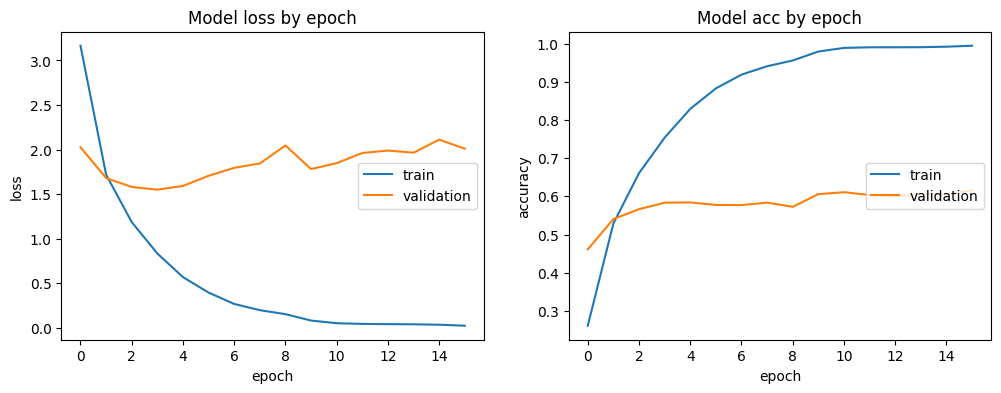

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [16]:
model.save('../models/model_127_species_exp7.h5')